# Initial Installation, Data Cleaning and Pre-processing

Before continuing to conclusion, we will install the necessary libraries and clean the data again. The reason for using another file is that the session gets crashed as the RAM gets used up while working at BERT

In [1]:
pip install convokit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#run this if convokit is unable to install 
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [4]:
from convokit import Corpus, download
corpus = Corpus(filename=download("movie-corpus"))

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [5]:
#Getting the dataframes
utterances = corpus.get_utterances_dataframe()
utterances = utterances.sample(n=20000, random_state=42) #Sample random 20000 rows in utterances
conversations = corpus.get_conversations_dataframe()
conversations.rename(columns={'meta.movie_idx': 'meta.movie_id'}, inplace=True) #rename columns for convenience
speakers = corpus.get_speakers_dataframe()
speakers.rename(columns={'meta.movie_idx': 'meta.movie_id'}, inplace=True)

In [6]:
#Getting the desired labels in the right format
conversations['meta.genre'] = conversations['meta.genre'].apply(lambda x: "drama" if x == "['drama']" else x)
conversations['meta.genre'] = conversations['meta.genre'].apply(lambda x: "horror" if x == "['horror']" else x)
conversations['meta.genre'] = conversations['meta.genre'].apply(lambda x: "thriller" if x == "['thriller']" else x)
conversations['meta.genre'] = conversations['meta.genre'].apply(lambda x: "comedy" if x == "['comedy']" else x)
conversations['meta.genre'] = conversations['meta.genre'].apply(lambda x: "documentary" if x == "['documentary']" else x)
conversations['meta.genre'] = conversations['meta.genre'].apply(lambda x: "romcom" if x == "['comedy', 'romance']" else x)

In [7]:
#Drop unncessary rows and columns that we will not use for our task 
conversations = conversations.loc[conversations['meta.genre'].isin(['drama', 'horror', 'thriller', 'comedy', 'documentary','romcom'])]
conversations = conversations.drop(columns=['meta.release_year', 'meta.rating', 'meta.votes'], axis=1)
speakers = speakers.drop(columns=['meta.credit_pos', 'meta.gender', 'meta.character_name'], axis=1)

In [8]:
#Merging the three dataframes
import pandas as pd
merged_df = conversations.merge(speakers, on='meta.movie_id').merge(utterances, on='meta.movie_id')
dfs = [conversations, utterances, speakers]
final_df = dfs[0]
for df in dfs[1:]:
    final_df = pd.merge(final_df, df, on=['meta.movie_id'], how='inner')

In [9]:
#Sampling 10000 rows
final_df = final_df.sample(n=10000, random_state=42)

In [10]:
#Splitting the dataframe into Train, Test and Validation set using Stratified Sampling
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
y = final_df['meta.genre']

#Split the data into training and the rest with 60:40 split
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=0) 
for train_index, test_val_index in stratified_split.split(final_df, y):
    train = final_df.iloc[train_index]
    test_val = final_df.iloc[test_val_index]

#Split the remaining 40% data into testing and validation 50:50 split
y_test_val = y.iloc[test_val_index]
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=0)
for test_index,val_index in stratified_split.split(test_val, y_test_val):
    test = test_val.iloc[test_index]
    val = test_val.iloc[val_index]

Before proceeding to pre-process, we will copy the dataframes so as to keep the original dataframe unchanged

In [11]:
conclusion_train = train.copy()
conclusion_val = val.copy()
conclusion_test = test.copy()

In [12]:
import spacy
import pandas as pd

nlp = spacy.load('en_core_web_sm')

def tokenize_text(text):
    return [token.text for token in nlp(text)]

conclusion_train['tokens'] = conclusion_train['text'].apply(tokenize_text)
conclusion_val['tokens'] = conclusion_val['text'].apply(tokenize_text)
conclusion_test['tokens'] = conclusion_test['text'].apply(tokenize_text)

In [13]:
import pandas as pd
from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer('english')

def stem_text(tokens):
    stemmed_tokens = []
    for token in tokens:
        stemmed_tokens.append(stemmer.stem(token))
    return stemmed_tokens

conclusion_train['tokens'] = conclusion_train['tokens'].apply(stem_text)
conclusion_val['tokens'] = conclusion_val['tokens'].apply(stem_text)
conclusion_test['tokens'] = conclusion_test['tokens'].apply(stem_text)

In [14]:
import spacy

nlp = spacy.load('en_core_web_sm')  

def lemmatize_text(text):
    lemmatized_tokens = []
    for token in text:
        lemmatized_tokens.append(nlp(token)[0].lemma_)
    return lemmatized_tokens

conclusion_train['tokens'] = conclusion_train['tokens'].apply(lemmatize_text)
conclusion_val['tokens'] = conclusion_val['tokens'].apply(lemmatize_text)
conclusion_test['tokens'] = conclusion_test['tokens'].apply(lemmatize_text)

In [15]:
import pandas as pd
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


def remove_stopwords(tokens):
  tok = []
  for token in tokens:
    if token not in stop_words:
      tok.append(token)
  return tok


conclusion_train['tokens'] = conclusion_train['tokens'].apply(remove_stopwords)
conclusion_val['tokens'] = conclusion_val['tokens'].apply(remove_stopwords)
conclusion_test['tokens'] = conclusion_test['tokens'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
conclusion_train['tokens'] = conclusion_train['tokens'].apply(lambda tokens: ' '.join(tokens))
conclusion_val['tokens'] = conclusion_val['tokens'].apply(lambda tokens: ' '.join(tokens))
conclusion_test['tokens'] = conclusion_test['tokens'].apply(lambda tokens: ' '.join(tokens))

A function is written to calculate the evaluation metrics

In [242]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

def evaluate(val, val_predictions):
    val_precision, val_recall, val_f1, support = precision_recall_fscore_support(val['meta.genre'], val_predictions, average='macro')
    val_accuracy = (val['meta.genre'] == val_predictions).mean()
    print(f'Validation accuracy: {val_accuracy:.3f}')
    print(f'Validation precision (macro-averaged): {val_precision:.3f}')
    print(f'Validation recall (macro-averaged): {val_recall:.3f}')
    print(f'Validation F1-score (macro-averaged): {val_f1:.3f}')

# Q.6 Conclusions and Future Work

The Classifier chosen is Random Forest with One Hot Vectorizer as the performance metrics showed the best results.

In [243]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

enc = OneHotEncoder(handle_unknown='ignore')
X_train = enc.fit_transform(conclusion_train[['tokens']])
y_train = conclusion_train['meta.genre']
X_test = enc.transform(conclusion_test[['tokens']])
y_test = conclusion_test['meta.genre']


clf = RandomForestClassifier().fit(X_train, y_train)
test_predictions = clf.predict(X_test)
evaluate(conclusion_test, test_predictions)

Validation accuracy: 0.886
Validation precision (macro-averaged): 0.952
Validation recall (macro-averaged): 0.737
Validation F1-score (macro-averaged): 0.813


Next, we will plot a confusion matrix of the true labels against the predict labels with the test set

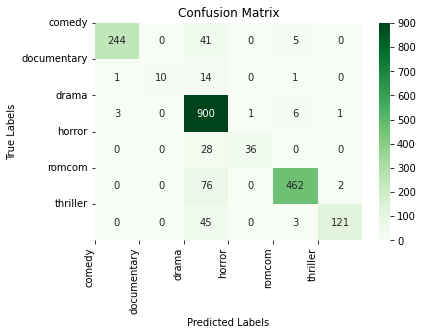

In [206]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
actual_genres = ['comedy', 'documentary', 'drama', 'horror', 'romcom', 'thriller']
cm = confusion_matrix(y_test, test_predictions)
sns.heatmap(cm, annot=True, cmap="Greens", fmt='d')
plt.xticks(range(len(actual_genres)), actual_genres, rotation=90, ha='right')
plt.xlabel('Predicted Labels')
plt.yticks(range(len(actual_genres)), actual_genres, rotation=0, ha='right')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

We can analyse all the list of movies that belonged to drama genre but were incorrectly predicted.

In [235]:
prediction = clf.predict(X_test)
for i in range(1999, 0, -1):
    if prediction[i] != 'drama' and y_test.iloc[i] == 'drama':
        print(f'Predicted genre: {prediction[i]}, Actual genre: {y_test.iloc[i]}, Movie name: {conclusion_test.iloc[i]["meta.movie_name_x"]}')

Predicted genre: romcom, Actual genre: drama, Movie name: magnolia
Predicted genre: comedy, Actual genre: drama, Movie name: the believer
Predicted genre: romcom, Actual genre: drama, Movie name: the verdict
Predicted genre: romcom, Actual genre: drama, Movie name: glengarry glen ross
Predicted genre: horror, Actual genre: drama, Movie name: the sweet hereafter
Predicted genre: romcom, Actual genre: drama, Movie name: glengarry glen ross
Predicted genre: romcom, Actual genre: drama, Movie name: u-turn
Predicted genre: comedy, Actual genre: drama, Movie name: the sweet hereafter
Predicted genre: comedy, Actual genre: drama, Movie name: panther
Predicted genre: romcom, Actual genre: drama, Movie name: magnolia
Predicted genre: thriller, Actual genre: drama, Movie name: the sweet hereafter


Here's a list of 10 movie dialogue and their true and predicted genres

In [209]:
prediction = clf.predict(X_test)
for i in range(10):
  if(prediction[i] == y_test.iloc[i]):
    #print(f"prediction[i],y_val.iloc[i])
    print(f'Right! Actual genre: {y_test.iloc[i]}, Predicted genre: {prediction[i]}')
  else:
    print(f'Wrong! Actual genre: {y_test.iloc[i]}, Predicted genre: {prediction[i]}')

Right! Actual genre: thriller, Predicted genre: thriller
Right! Actual genre: drama, Predicted genre: drama
Right! Actual genre: drama, Predicted genre: drama
Right! Actual genre: comedy, Predicted genre: comedy
Wrong! Actual genre: romcom, Predicted genre: drama
Right! Actual genre: romcom, Predicted genre: romcom
Right! Actual genre: drama, Predicted genre: drama
Right! Actual genre: romcom, Predicted genre: romcom
Right! Actual genre: drama, Predicted genre: drama
Wrong! Actual genre: thriller, Predicted genre: drama


Now, we will build a function that pre-processes the text and encodes the tokens before predicting the genres of text manually

In [210]:
def predict_genre(text):
  tokens = tokenize_text(text)
  stemmed_tokens = stem_text(tokens)
  lemmatized_tokens = lemmatize_text(stemmed_tokens)
  tokens_processed = remove_stopwords(lemmatized_tokens)
  preprocessed_text = ' '.join(tokens_processed)
  encoded_text = enc.transform([[preprocessed_text]])
  prediction = clf.predict(encoded_text)
  print(f"Predicted genre: {prediction[0]}")

In [239]:
text = "It's awfully nice of you to show me around like this."
predict_genre(text)
text = "Tell him you're going to elope with him."
predict_genre(text)
text = "Happiness is real when shared." #Quote from my favourite movie Into The Wild, 100% recommended
predict_genre(text)
text = "I love you."
predict_genre(text)
text = "Shhhhhh."
predict_genre(text)
text = "Is there any way you could lend me some money? Maybe... 20 million dollars?"
predict_genre(text)
text = "I am Vengeance"
predict_genre(text)






/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


Predicted genre: romcom
Predicted genre: comedy
Predicted genre: drama
Predicted genre: romcom


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


Predicted genre: horror
Predicted genre: drama
Predicted genre: drama


As evident from the results, a lot of movies are incorrectly predicted as drama. 